In [1]:
from resultProcessing import *
from genetic import Genetic 
from busData import *
import matplotlib.pyplot as plt
import networkx as nx

In [10]:
def loadNetwork(filePath='./data/routeData_parsed.csv'):
    genetic = Genetic('./data/stopData_parsed.csv', './data/population.csv', [0], 1, 10, 2)
    busNetwork = genetic.bestNetwork[0]

    with open(filePath, encoding='utf-8') as f:
        r = csv.reader(f)
        busNetwork.busData.routeList = []
        for i, line in enumerate(r):
            if line[0] == 'id':
                continue

            stopIdList = line[3].split('/')
            if filePath != './data/routeData_parsed.csv':
                _stopIdList = [*stopIdList]
                stopIdList = [*_stopIdList, *reversed(_stopIdList[:-1])]
            busNetwork.busData.routeList.append(BusRoute(f'{i}-{line[0]}', line[1], line[2], stopIdList))
    return busNetwork



In [3]:
resultPath = './Results/analyze/'

In [101]:
def plot_degree_dist(G, title):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=range(min(degrees)-0.5, max(degrees) + 1.5, 1))
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    # plt.show()
    plt.savefig(f'{resultPath}{title}.png', dpi = 200)


In [5]:
def createCommunityNetworkX(busNetwork):
    network = nx.DiGraph()

    nodeIdList = []
    nodeAttributeDict = {}
    communityDict = {}

    for i, name in enumerate(BusData.communityDict):
        nodeIdList.append(i)
        nodeAttributeDict[i] = {
            'name': name,
            'stopIdList': BusData.communityDict[name]['stopIdList'],
            'population': BusData.communityDict[name]['population'],
            'latitude': np.mean([busNetwork.busData.getStopById(stopId).latitude for stopId in BusData.communityDict[name]['stopIdList'] ]),
            'longitude': np.mean([busNetwork.busData.getStopById(stopId).longitude for stopId in BusData.communityDict[name]['stopIdList'] ])
        }
        communityDict[name] = i

    network.add_nodes_from(nodeIdList)
    nx.set_node_attributes(network, nodeAttributeDict)

    edgeAttributeDict = {}

    for route in busNetwork.busData.routeList:
        for i in range(len(route.stopIdList)-1):
            source = busNetwork.busData.getStopById(route.stopIdList[i])
            target = busNetwork.busData.getStopById(route.stopIdList[i+1])
            if source.region != target.region:
                edge = (communityDict[source.region], communityDict[target.region])
                if edge not in edgeAttributeDict.keys():
                    edgeAttributeDict[edge] = {
                        'weight': 0,
                        'routeId': f'{communityDict[source.region]}-0'
                    }
                edgeAttributeDict[edge]['weight'] += 1
    
    edgeList = []
    weightList = []
    for edge in edgeAttributeDict.keys():
        weightList.append(edgeAttributeDict[edge]['weight'])
        edgeList.append(edge)
    
    weightList = np.array(weightList, np.float32)
    weightList -= np.min(weightList)
    weightList /= np.max(weightList)
    weightList += 1

    for i, edge in enumerate(edgeAttributeDict.keys()):
        edgeAttributeDict[edge]['norm_weight'] = weightList[i]

    network.add_edges_from(edgeList)
    nx.set_edge_attributes(network, edgeAttributeDict)

    return network

In [40]:
def saveNetworkxImg(network, resultPath, title = ''):

    plt.figure(figsize=(15,10), facecolor='white')
    plt.tight_layout()
    plt.rc('font', family='HYHeadLine-Medium') # For Windows

    ax = plt.gca()
    ax.set_facecolor("white")

    #pos = nx.spring_layout(genetic.network) # layout 조정 가능
    #pos = nx.kamada_kawai_layout(genetic.network)
    #pos = nx.random_layout(genetic.network)


    nodes = list(network.nodes(data = True))
    edges = list(network.edges(data = True))

    pos = {node[0] : [node[1]['longitude'], node[1]['latitude']] for node in nodes}
    node_labels = {node[0] : node[1]['name'] for node in nodes}

    colorList = ['red','orange','green', 'skyblue',  'lightpink', 'purple',  'brown','black']

    node_colors = [colorList[node[0]%8] for node in nodes]
    node_sizes = [node[1]['population']//10 for node in nodes]
    edge_colors = [colorList[int(edge[2]['routeId'].split('-')[0])%8] for edge in edges]
    edge_widths = [edge[2]['norm_weight']*2 for edge in edges]


    nx.draw_networkx_nodes(network, node_size = node_sizes, node_color = node_colors, alpha = 0.5, pos = pos, ax = ax)
    nx.draw_networkx_edges(network, width = edge_widths, edge_color = edge_colors, alpha = 1, pos = pos, ax = ax, connectionstyle="arc3,rad=0.1")

    nx.draw_networkx_labels(network, pos=pos, font_size=8, labels=node_labels, font_family='HYHeadLine-Medium')
    # nx.draw_networkx_nodes(network, node_size = 40, node_color = 'grey', alpha = 0.3, pos = pos, ax = ax)
    # nx.draw_networkx_edges(network, width = 2, edge_color = 'red', alpha = 0.7, pos = pos, ax = ax)

    # ax.set_title(title, fontsize = 32)

    # image 저장
    plt.savefig(resultPath + title + '.png', dpi = 200)

    plt.close()

In [41]:
def plot_strength_hist(G, title):
    plt.figure(figsize=(15,5), facecolor='white')

    x = []
    for node in G.nodes(data=True):
        x.append(node[1]['name'])
    
    y = [0]*len(x)
    for edge in G.edges(data=True):
        y[edge[0]] += edge[2]['weight']
        y[edge[1]] += edge[2]['weight']
        
    plt.plot(x, y)
    # plt.title(title)
    plt.xlabel('Region Name')
    plt.ylabel('Strength')
    # plt.show()
    plt.savefig(f'{resultPath}{title}.png', dpi = 200)

In [42]:
def printEdgeCnt(busNetwork):
    edgeCnt = 0
    for route in busNetwork.busData.routeList:
        edgeCnt += len(route.stopIdList)-1
    print(edgeCnt)

3144


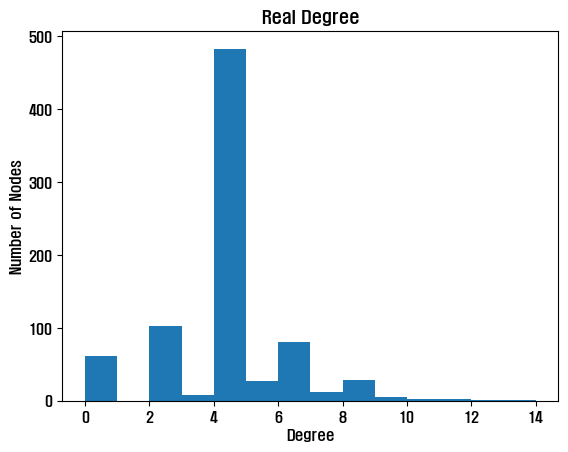

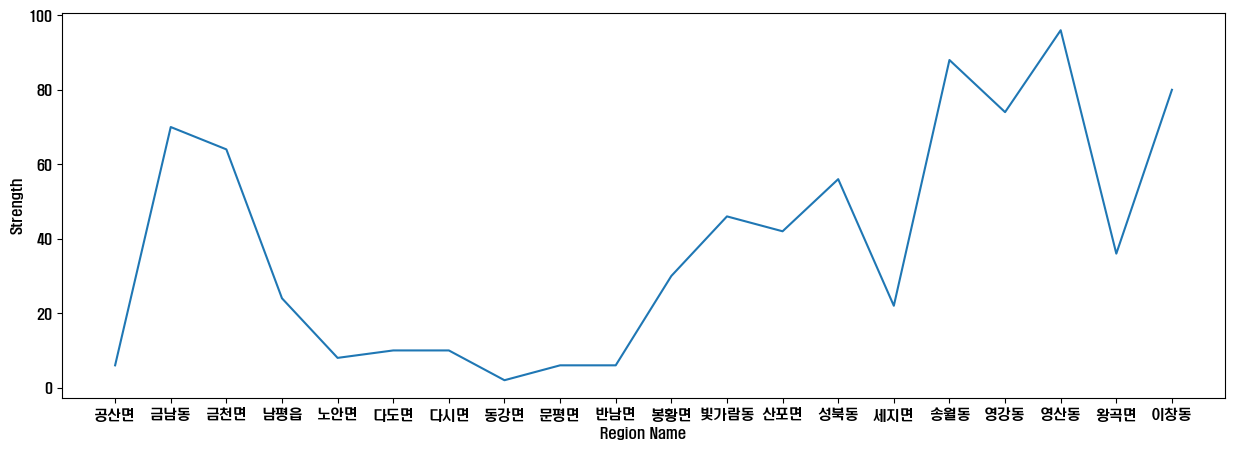

In [102]:
realNetwork = loadNetwork()
real = createCommunityNetworkX(realNetwork)
saveImg(createNetworkX(realNetwork), resultPath, 'Real Network')
plot_degree_dist(createNetworkX(realNetwork), 'Real Degree')
saveNetworkxImg(real, resultPath, 'Real')
plot_strength_hist(real, 'Real Strength')
printEdgeCnt(realNetwork)

2090


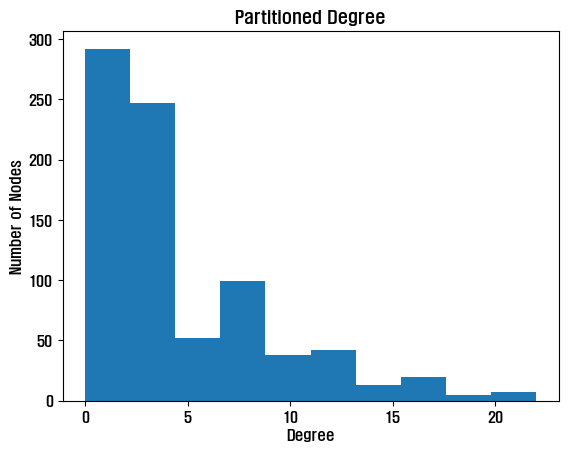

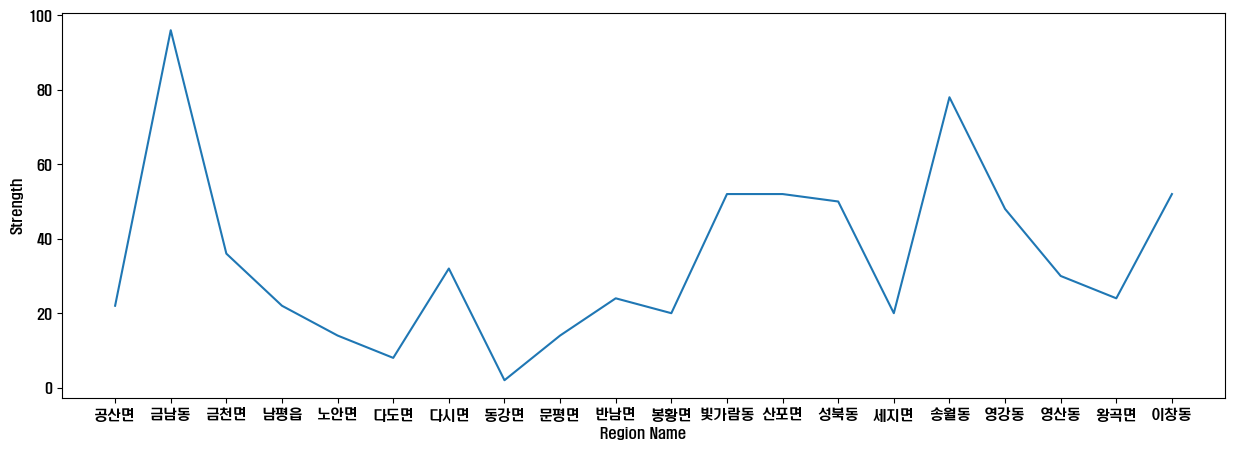

In [44]:
partitionedNetwork = loadNetwork('./Results/partitioned 1/나주시 20 - 0.01333835783756349.csv')
partitioned = createCommunityNetworkX(partitionedNetwork)
saveImg(createNetworkX(partitionedNetwork), resultPath, 'Partitioned Network')
plot_degree_dist(createNetworkX(partitionedNetwork), 'Partitioned Degree')
saveNetworkxImg(partitioned, resultPath, 'Partitioned')
plot_strength_hist(partitioned, 'Partitioned Strength')
printEdgeCnt(partitionedNetwork)

1842


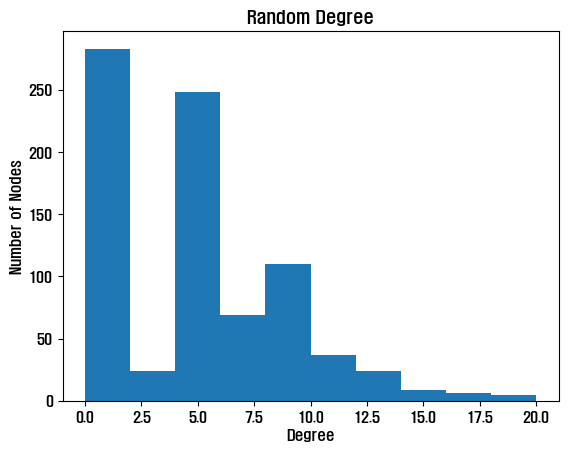

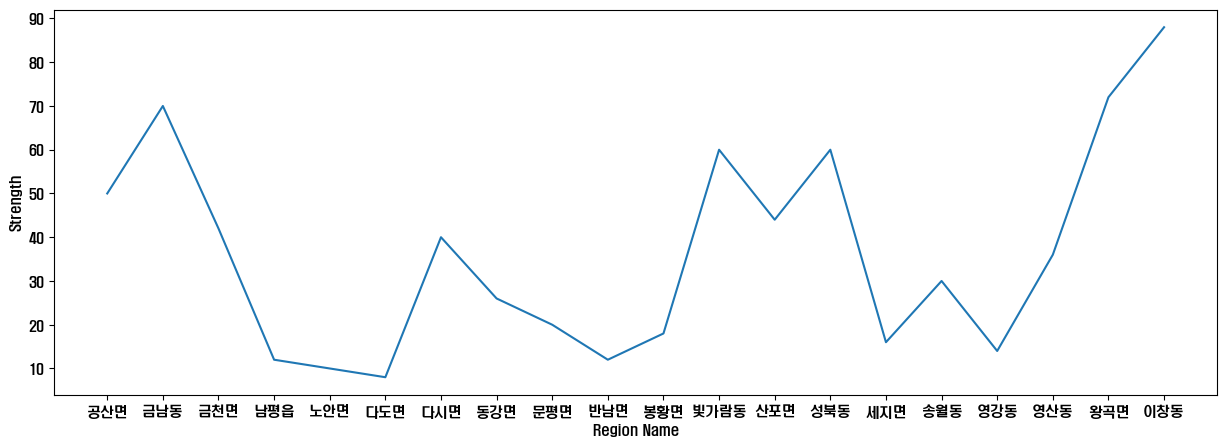

In [46]:
randomNetwork = loadNetwork('./Results/random 1/Random 30 - 0.008673733081363785.csv')
random = createCommunityNetworkX(randomNetwork)
saveImg(createNetworkX(randomNetwork), resultPath, 'Random Network')
plot_degree_dist(createNetworkX(randomNetwork), 'Random Degree')
saveNetworkxImg(random, resultPath, 'Random')
plot_strength_hist(random, 'Random Strength')
printEdgeCnt(randomNetwork)

1822


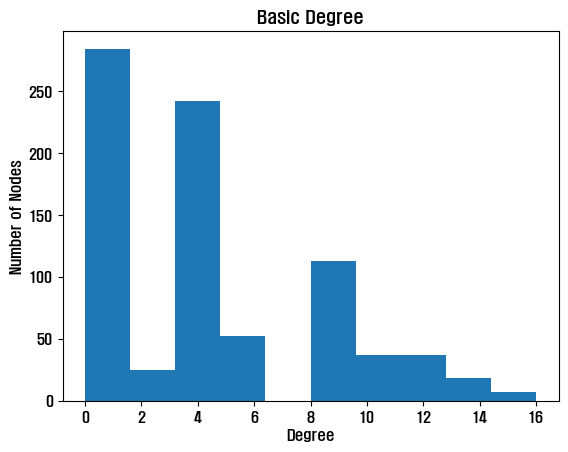

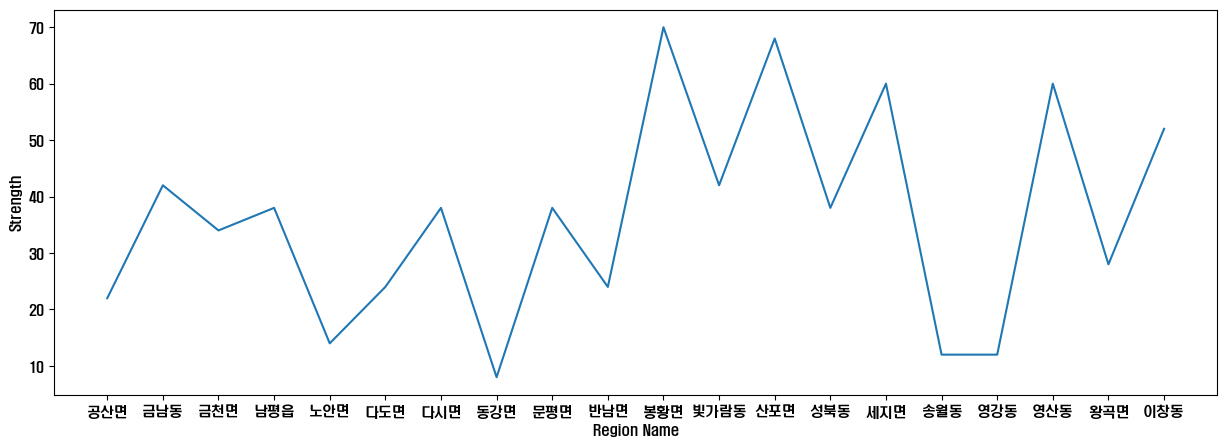

In [47]:
basicNetwork = loadNetwork('./Results/basic 1/Basic 30 - 0.009538004077015206.csv')
basic = createCommunityNetworkX(basicNetwork)
saveImg(createNetworkX(basicNetwork), resultPath, 'Basic Network')
plot_degree_dist(createNetworkX(basicNetwork), 'Basic Degree')
saveNetworkxImg(basic, resultPath, 'Basic')
plot_strength_hist(basic, 'Basic Strength')
printEdgeCnt(basicNetwork)

In [36]:
def plot_all_strength(GList, nameList, title):
    plt.figure(figsize=(15,5), facecolor='white')

    for G, name in zip(GList, nameList):
        x = []
        
        for node in G.nodes(data=True):
            x.append(node[1]['name'])
        
        y = [0]*len(x)
        for edge in G.edges(data=True):
            y[edge[1]] += edge[2]['weight']
            
        plt.plot(x, y, label=name)

    # plt.title(title)
    plt.xlabel('Region Name')
    plt.ylabel('Strength')
    plt.legend()
    # plt.show()
    plt.savefig(f'{resultPath}{title}.png', dpi = 200)

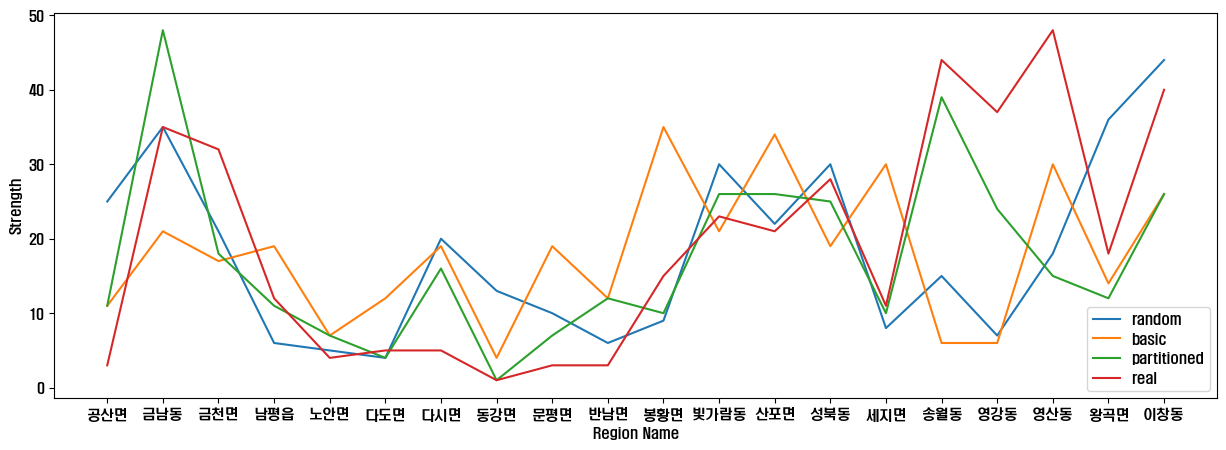

In [37]:
plot_all_strength([random, basic, partitioned, real], ['random', 'basic', 'partitioned', 'real'], 'All Strength')

In [96]:
def drawScoreFig(model):
    plt.figure(figsize=(7,5), facecolor='white')
    for i in range(1,5):
        resultDict = {}
        for file in os.listdir(f'./Results/{model} {i}/'):
            if model == 'partitioned' and '나주시' not in file:
                continue
            if 'csv' in file:
                resultDict[int(file.split(' - ')[0].split(' ')[1])] = float(file.split(' - ')[1].split('.csv')[0])

        x = []
        y = []
        if model == 'partitioned':
            for j in range(1, 11):
                x.append(j)
                y.append(0)
            for j in range(1, 21):
                x.append(j+10)
                y.append(resultDict[j])
        else:
            for j in range(1, 31):
                x.append(j)
                y.append(resultDict[j])
            

        plt.plot(x, y, label=f'{model} {i}')
    plt.ylabel('Weighted Passenger Satisfaction')
    plt.xlabel('# of Generations')
    plt.legend()
    plt.savefig(f'./Results/analyze/{model} score.png', dpi = 200)

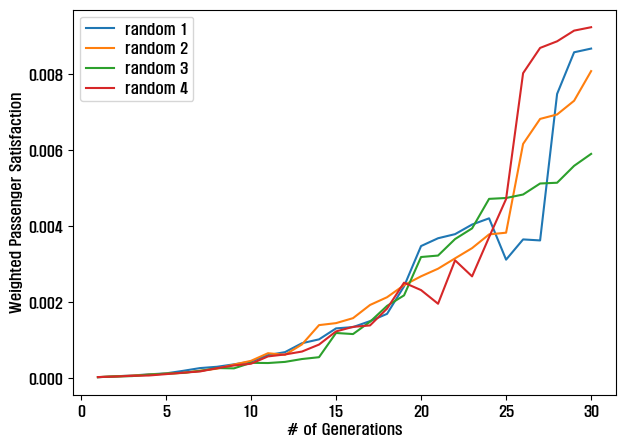

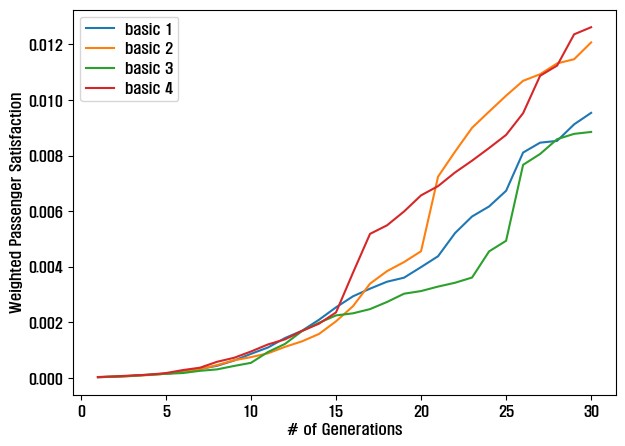

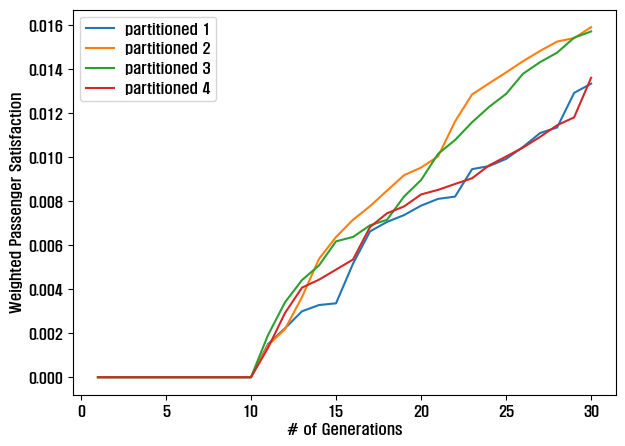

In [97]:
drawScoreFig('random')
drawScoreFig('basic')
drawScoreFig('partitioned')

In [100]:
filePathList = ['random', 'basic', 'partitioned']

for filePath in filePathList:
    for i in range(1, 5):
        for fileName in os.listdir(f'./Results/{filePath} {i}/'):
            if '30 - ' in fileName and 'csv' in fileName:
                network = loadNetwork(f'./Results/{filePath} {i}/{fileName}')
                print(filePath, '-', i)
                printEdgeCnt(network)
            elif '나주시 20 - ' in fileName and 'csv' in fileName:
                network = loadNetwork(f'./Results/{filePath} {i}/{fileName}')
                print(filePath, '-', i)
                printEdgeCnt(network)


random - 1
1842
random - 2
1772
random - 3
1660
random - 4
1702
basic - 1
1822
basic - 2
1870
basic - 3
1834
basic - 4
1922
partitioned - 1
2090
partitioned - 2
2072
partitioned - 3
2128
partitioned - 4
2106
